### 1. Load Packages

In [38]:
# Package
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
from IPython.display import display
plt.style.use('default')

### 2. Self-defined Functions

In [39]:
def long_signal(dataframe, string='leading_indicator'):
    dataframe_1 = dataframe.copy()
    dataframe_1 = pd.DataFrame(dataframe_1[string].rename('TW50_signal', inplace=True))
    dataframe_1['MMF_signal'] = dataframe_1['TW50_signal']
    dataframe_1['TW50_D_signal'] = dataframe_1['TW50_signal']

    for index in range(len(dataframe.index)-1):
        if index <= 136:
            if dataframe.iloc[index+1, 0] - dataframe.iloc[index, 0] > 0:
                dataframe_1.iloc[index+1, 0] = 1
                dataframe_1.iloc[index+1, 1] = 0
                dataframe_1.iloc[index+1, 2] = 0
            else:
                dataframe_1.iloc[index+1, 0] = 0
                dataframe_1.iloc[index+1, 1] = 1
                dataframe_1.iloc[index+1, 2] = 0
        else:
            if dataframe.iloc[index+1, 0] - dataframe.iloc[index, 0] > 0 and dataframe.iloc[index+1, 0] <= 102:
                dataframe_1.iloc[index+1, 0] = 0
                dataframe_1.iloc[index+1, 1] = 0
                dataframe_1.iloc[index+1, 2] = 1
            elif dataframe.iloc[index+1, 0] - dataframe.iloc[index, 0] > 0 and dataframe.iloc[index+1, 0] > 102:
                dataframe_1.iloc[index+1, 0] = 1
                dataframe_1.iloc[index+1, 1] = 0
                dataframe_1.iloc[index+1, 2] = 0
            else:
                dataframe_1.iloc[index+1, 0] = 0
                dataframe_1.iloc[index+1, 1] = 1
                dataframe_1.iloc[index+1, 2] = 0

    dataframe_1.iloc[0,0] = 0
    dataframe_1.iloc[0,1] = 1
    dataframe_1.iloc[0,2] = 0
    return dataframe_1


def fee_calculation(signal, column):
    dataframe_1 = signal.iloc[:, column].copy()
    dataframe_1 = dataframe_1.replace(1, 0)
    for index in range(len(signal.index)-1):
        if (signal.iloc[index+1, column] - signal.iloc[index, column] == 1) \
                or (signal.iloc[index+1, column] - signal.iloc[index, column] == -1):
                dataframe_1[index+1] = -0.002425
    return dataframe_1


def dividend_reinvest(signal, dividend, column=0):
    dataframe_1 = signal.iloc[:, column].copy()
    dataframe_1 = dataframe_1.replace(1, 0)
    for index in range(len(signal.index)):
        if signal.iloc[index, column] == dividend.iloc[index, 0]:
            dataframe_1[index+2] = dividend.iloc[index, 1]
    return dataframe_1

def get_performance_stats(prices, rfr=0.02, label=None):
    """
    Generate the performance stats for a time-series price data.

    :param prices: pd.Series or np.array
    :param rfr: risk-free returns as pd.Series or np.array (0 by default)
    :param label: strings, column label as string
    :return: stats - pd.dataframe with statistics (performance measures) organized by row with exact labels:
             Tot Return     - total cumulative return over the whole period
             Avg Return     - average annualised return
             Rf Rate        - average annualised risk-free return
             Volatility     - annualised standard deviation
             Sharpe Ratio   - annualised Sharpe Ratio
             Skewness       - skewness (same frequency as prices)
             Kurtosis       - kurtosis (same frequency as prices)
             HWM            - High Water Mark price, i.e. the highest price ever achieved
             HWM date       - date of the HWM
             MDD            - Maximum Drawdown as positive proportional loss from prior peak
             Peak date      - Date of the MDD peak
             Trough date    - Date of the MDD trough
             Recession Date - Date the asset recovered from Drawdown loss
             MDD Duration   - MDD duration in days from peak to recovery date
    """

    month = 12 # Number of month in a year
    # Pre-allocate empty dataframe
    if label is None:
        stats = pd.DataFrame(index=[0])
    else:
        stats = pd.DataFrame(index=[label])

    returns = prices.pct_change()
    last_index = prices.shape[0] - 1
    # need - 1 since array referencing starts from 0
    p_last = prices[last_index]
    stats['Total Return'] = (p_last - prices[0]) / prices[0]
    # (prices[ prices.shape[0]] / prices[0])-1 does same in 1 step
    stats['Avg Return'] = (1 + stats['Total Return']) ** (12 / len(prices)) - 1
    stats['Rf Rate'] = rfr
    # Note the convention for interbank rate is 365 days
    stats['Volatility'] = returns.std() * np.sqrt(month)
    # sigma*sqrt(T)
    stats['Sharpe Ratio']  = (stats['Avg Return'] - stats['Rf Rate']) / stats['Volatility']
    # Sharpe Ratio
    stats['Skewness'] = returns.skew()
    # For normal should be 0
    stats['Kurtosis'] = returns.kurtosis()
    # For normal should be 3
    hwm_time = prices.idxmax()
    # returns argument corresponding to max price (i.e. Timestamp)
    stats['HWM'] = prices.max()
    # returns max price
    stats['HWM date'] = hwm_time.date()
    # converts Timestamp('2018-01-26 00:00:00') to datetime.date(2018, 1, 26)
    dd = prices.cummax() - prices
    # get all Drawdowns: differences between cumulative max price and current price
    end_mdd  = dd.idxmax()
    start_mdd = prices[:end_mdd].idxmax()
    # Maximum Draw down as positive proportional loss from peak
    stats['MDD'] = 1 - prices[end_mdd] / prices[start_mdd]
    # (same as P_start - P_end) / P_start
    stats['Peak Date'] = start_mdd.date()
    stats['Trough Date'] = end_mdd.date()
    bool_p = prices[end_mdd:] > prices[start_mdd]
    # True/False current price > price of DD peak

    if bool_p.idxmax().date() > bool_p.idxmin().date():
        stats['Recession Date'] = bool_p.idxmax().date()
        stats['MDD Duration'] = (stats['Recession Date'] - stats['Peak Date'])[0].days
        # MDD duration in days from peak to recovery date
    else:
        stats['Recession Date'] = stats['MDD Duration']  = 'Yet to recover'
    return stats

### 3. Load Data & Data Processing

In [40]:
os.chdir('C:/Python/Data')
df_leading_indicator = pd.read_csv('leading_indicator.csv', index_col=0, na_values='n/a').dropna()
df_TWCI = pd.read_csv('TWII.csv', index_col=0, na_values='null').dropna()
df_tw50_nav = pd.read_csv('Taiwan_50.csv', index_col=0, na_values='n/a').dropna()
df_tw50_div = pd.read_csv('Taiwan_50_dividend.csv', index_col=0, na_values='n/a')
df_tw50_D_nav = pd.read_csv('Taiwan_50_double.csv', index_col=0, na_values='n/a').dropna()
df_mmf_nav =  pd.read_csv('MMF.csv', index_col=0, na_values='n/a').dropna()

df_leading_indicator.index = pd.to_datetime(df_leading_indicator.index, format='%Y/%m/%d')
df_TWCI.index = pd.to_datetime(df_TWCI.index, format='%Y/%m/%d')
df_tw50_nav.index = pd.to_datetime(df_tw50_nav.index, format='%Y/%m/%d')
df_tw50_div.index = pd.to_datetime(df_tw50_div.index, format='%Y/%m/%d')
df_tw50_D_nav.index = pd.to_datetime(df_tw50_D_nav.index, format='%Y/%m/%d')
df_mmf_nav.index = pd.to_datetime(df_mmf_nav.index, format='%Y/%m/%d')

df_tw50_month_return = df_tw50_nav.pct_change().resample('M').agg(lambda x: (x + 1).prod() - 1)
df_tw50_month_return = pd.DataFrame(df_tw50_month_return['NAV'].rename('monthly_return', inplace=True))

df_tw50_D_month_return = df_tw50_D_nav.pct_change().resample('M').agg(lambda x: (x + 1).prod() - 1)
df_tw50_D_month_return = pd.DataFrame(df_tw50_D_month_return['NAV'].rename('monthly_return', inplace=True))

df_mmf_month_return = df_mmf_nav.pct_change().resample('M').agg(lambda x: (x + 1).prod() - 1)
df_mmf_month_return = pd.DataFrame(df_mmf_month_return['NAV'].rename('monthly_return', inplace=True))

### 4. Taiwan Leading Indicator VS Taiwan Composite Index

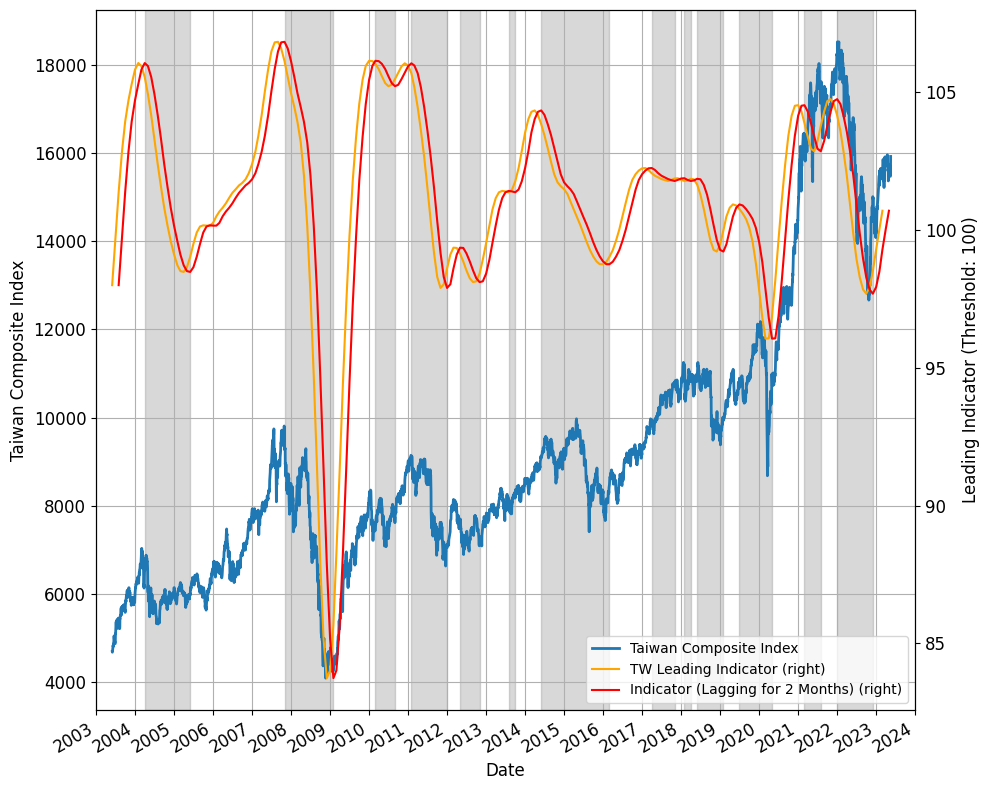

In [41]:
fig = plt.figure()
ax1 = df_TWCI['Adj Close'].rename('Taiwan Composite Index').plot(grid=True, figsize=(10, 8), fontsize=12, linewidth=2, x_compat=True)
ax2 = df_leading_indicator['leading_indicator'].shift(-2).rename('TW Leading Indicator').plot(secondary_y=True, ax=ax1, color='orange', fontsize=12, x_compat=True, legend=False)
ax3 = df_leading_indicator['leading_indicator'][2:].rename('Indicator (Lagging for 2 Months)').plot(secondary_y=True, ax=ax1, color='red', fontsize=12, x_compat=True, legend=False)
# Combine the legends together
handles, labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
# For 2 y-axis
ax1.set_ylabel('Taiwan Composite Index', fontsize=12)
ax2.set_ylabel('Leading Indicator (Threshold: 100)', fontsize=12)
# For x-axis
ax1.set_xlabel('Date', fontsize=12)
# For ticks at x-axis
xticks = pd.date_range(dt.datetime(2003,1,1), dt.datetime(2024,1,1), freq='YS')
ax1.xaxis.set_major_locator(matplotlib.dates.YearLocator(base=1))
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
# For left and right bound of x-axis
left = dt.date(2003,1,1)
right = dt.date(2024,1,1)
plt.gca().set_xbound(left, right)

# For MMF Investment period
trans = transforms.blended_transform_factory(ax1.transData, ax1.transAxes)
startdate1 = dt.date(2004, 4, 1)
enddate1 = dt.date(2005, 6, 1)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2007, 11, 1)
enddate1 = dt.date(2009, 2, 1)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2010, 3, 1)
enddate1 = dt.date(2010, 9, 1)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2011, 2, 1)
enddate1 = dt.date(2012, 1, 1)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2012, 5, 1)
enddate1 = dt.date(2012, 11, 1)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2013, 8, 1)
enddate1 = dt.date(2013, 10, 1)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2014, 6, 1)
enddate1 = dt.date(2016, 3, 1)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2017, 4, 1)
enddate1 = dt.date(2017, 11, 1)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2018, 2, 1)
enddate1 = dt.date(2018, 4, 1)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2018, 6, 1)
enddate1 = dt.date(2019, 2, 1)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2019, 7, 1)
enddate1 = dt.date(2020, 5, 1)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2021, 3, 1)
enddate1 = dt.date(2021, 8, 1)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2022, 1, 1)
enddate1 = dt.date(2022, 12, 1)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

plt.legend(handles,labels, fontsize=10, loc='lower right')
plt.tight_layout()
plt.show()

### 5. Market Timing Strategy - Investment Signal Generation

In [42]:
df_signal = long_signal(df_leading_indicator)
df_signal.index = df_tw50_month_return.index
df_tw50_div.index = df_tw50_month_return.index

In [43]:
df_signal

,TW50_signal,MMF_signal,TW50_D_signal
date,,,
2003-06-30,0.0,1.0,0.0
2003-07-31,1.0,0.0,0.0
2003-08-31,1.0,0.0,0.0
2003-09-30,1.0,0.0,0.0
2003-10-31,1.0,0.0,0.0
...,...,...,...
2023-01-31,0.0,0.0,1.0
2023-02-28,0.0,0.0,1.0
2023-03-31,0.0,0.0,1.0


### 6. Fee Calculation, Dividend Reinvestment and Strategy Cumulative Return Calculation

In [44]:
df_sales_charge_TW_50 = fee_calculation(df_signal, column=0)
df_sales_charge_TW_50_D = fee_calculation(df_signal, column=2)

df_dividend = dividend_reinvest(df_signal, df_tw50_div, column=0)

pd_return_TW_50 = df_signal.iloc[:, 0].mul(df_tw50_month_return.iloc[:, 0], axis=0).replace(-0, 0)
pd_return_TW_50_D = df_signal.iloc[:, 2].mul(df_tw50_D_month_return.iloc[:, 0], axis=0).replace(-0, 0)
pd_return_MMF = df_signal.iloc[:, 1].mul(df_mmf_month_return.iloc[:, 0], axis=0).replace(-0, 0)
pd_return = pd_return_TW_50 + pd_return_MMF + pd_return_TW_50_D + df_sales_charge_TW_50 + df_sales_charge_TW_50_D + df_dividend

### 7. Converting Cum. Return Series Into NAV for Strategy & Benchmark (Initial NAV: 10)

In [45]:
initial_NAV = 10
initial = pd.Series({'2003-05-31':10})
initial.index = pd.to_datetime(initial.index, format='%Y-%m-%d')

pd_cum_return_strat = initial_NAV * (1 + pd_return).cumprod()
pd_cum_return_strat = pd.concat([initial, pd_cum_return_strat], axis=0)
pd_cum_return_strat = pd_cum_return_strat.rename('Strategy')

df_tw50_month_return_1 = df_tw50_month_return.add(df_tw50_div.iloc[:, 1].shift(2).replace(np.nan, 0), axis=0)
pd_cum_return_TW_50 = initial_NAV * (1 + df_tw50_month_return_1).cumprod()
pd_cum_return_TW_50.columns = [0]
pd_cum_return_TW_50.index.name = None
pd_cum_return_TW_50 = pd.concat([initial, pd_cum_return_TW_50], axis=0)
pd_cum_return_TW_50 = pd_cum_return_TW_50[0].rename('TW_50')

pd_cum_return = pd.concat([pd_cum_return_strat, pd_cum_return_TW_50], axis=1)

In [46]:
pd_cum_return.head(1)

,Strategy,TW_50
2003-05-31,10.0,10.0


In [47]:
pd_cum_return.tail(1)

,Strategy,TW_50
2023-05-31,142.585253,59.304973


### 8. Backtesting Plot for Strategy & Benchmark

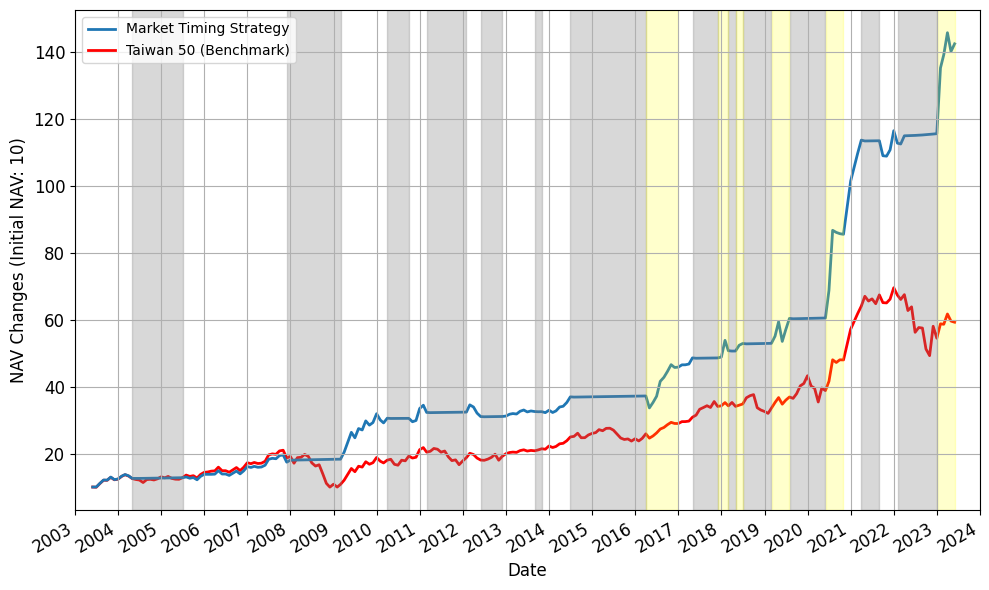

In [48]:
fig = plt.figure()
ax1 = pd_cum_return['Strategy'].rename('Market Timing Strategy').plot(grid=True, figsize=(10, 6), fontsize=12, linewidth=2, x_compat=True, zorder=1)
ax2 = pd_cum_return['TW_50'].rename('Taiwan 50 (Benchmark)').plot(grid=True, color='red', figsize=(10, 6), fontsize=12, linewidth=2, x_compat=True, zorder=0)
plt.legend(fontsize=10, loc='upper left')
# For labels
plt.ylabel('NAV Changes (Initial NAV: 10)', fontsize=12)
plt.xlabel('Date', fontsize=12)
# For ticks at x-axis
#xticks = pd.date_range(dt.datetime(2003,1,1), dt.datetime(2024,1,1), freq='YS')
ax1.xaxis.set_major_locator(matplotlib.dates.YearLocator(base=1))
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
# For left and right bound of x-axis
left = dt.date(2003,1,1)
right = dt.date(2024,1,1)
plt.gca().set_xbound(left, right)

# For MMF Investment period
trans = transforms.blended_transform_factory(ax1.transData, ax1.transAxes)
startdate1 = dt.date(2004, 5, 1)
enddate1 = dt.date(2005, 6, 30)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2007, 12, 1)
enddate1 = dt.date(2009, 2, 28)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2010, 4, 1)
enddate1 = dt.date(2010, 9, 30)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2011, 3, 1)
enddate1 = dt.date(2012, 1, 31)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2012, 6, 1)
enddate1 = dt.date(2012, 11, 30)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2013, 9, 1)
enddate1 = dt.date(2013, 10, 31)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2014, 7, 1)
enddate1 = dt.date(2016, 3, 31)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2017, 5, 1)
enddate1 = dt.date(2017, 11, 30)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2018, 3, 1)
enddate1 = dt.date(2018, 4, 30)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2018, 7, 1)
enddate1 = dt.date(2019, 2, 28)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2019, 8, 1)
enddate1 = dt.date(2020, 5, 31)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2021, 4, 1)
enddate1 = dt.date(2021, 8, 31)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

startdate1 = dt.date(2022, 2, 1)
enddate1 = dt.date(2022, 12, 31)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='grey', alpha=0.3)
ax1.add_patch(rect1)

# For TW50 Double Investment period
startdate1 = dt.date(2016, 4, 1)
enddate1 = dt.date(2016, 12, 31)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='yellow', alpha=0.2)
ax1.add_patch(rect1)

startdate1 = dt.date(2017, 12, 1)
enddate1 = dt.date(2018, 2, 28)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='yellow', alpha=0.2)
ax1.add_patch(rect1)

startdate1 = dt.date(2018, 5, 1)
enddate1 = dt.date(2018, 6, 30)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='yellow', alpha=0.2)
ax1.add_patch(rect1)

startdate1 = dt.date(2019, 3, 1)
enddate1 = dt.date(2019, 7, 31)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='yellow', alpha=0.2)
ax1.add_patch(rect1)

startdate1 = dt.date(2020, 6, 1)
enddate1 = dt.date(2020, 10, 31)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='yellow', alpha=0.2)
ax1.add_patch(rect1)

startdate1 = dt.date(2023, 1, 1)
enddate1 = dt.date(2023, 5, 31)
start1 = mdates.date2num(startdate1)
end1 = mdates.date2num(enddate1)
rect1 = patches.Rectangle((start1, 0), width=end1-start1, height=1, transform=trans, color='yellow', alpha=0.2)
ax1.add_patch(rect1)

plt.tight_layout()
plt.show()

### 9. Comparison on Average Returns Between Indicator Increasing Period and Indicator Decreasing Period

In [49]:
list_investment = []
for j in range(len(df_signal.index)):
    if df_signal.iloc[j, 1] == 0:
        list_investment.append(df_tw50_month_return.iloc[j,0])
print('Avg. Return During Indicator Increasing Period:', ((sum(list_investment) / len(list_investment))* 100).round(2), '%')

Avg. Return During Indicator Increasing Period: 1.72 %


In [50]:
list_MMF = []
for j in range(len(df_signal.index)):
    if df_signal.iloc[j, 1] == 1:
        list_MMF.append(df_tw50_month_return.iloc[j,0])
print('Avg. Return During Indicator Decreasing Period:', ((sum(list_MMF) / len(list_MMF))* 100).round(2), '%')

Avg. Return During Indicator Decreasing Period: -0.46 %


### 10. Performance Stats for Strategy & Benchmark

In [51]:
stats_summary = pd.concat([get_performance_stats(pd_cum_return['Strategy'],label='Strat_03-23'),
                   get_performance_stats(pd_cum_return['Strategy'][:136],label='Strat_03-14'),
                   get_performance_stats(pd_cum_return['Strategy'][136:],label='Strat_14-23'),
                   get_performance_stats(pd_cum_return['TW_50'],label='TW 50')], axis=0)
display(stats_summary)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
Strat_03-23,13.258525,0.141469,0.02,0.147335,0.824443,1.557258,6.233405,145.906686,2023-03-31,0.098961,2019-04-30,2019-05-31,2019-07-31,92
Strat_03-14,2.692202,0.122160,0.02,0.143295,0.712930,0.831884,1.725943,36.977363,2014-06-30,0.102762,2012-02-29,2012-06-30,2014-05-31,822
Strat_14-23,2.859845,0.166908,0.02,0.153495,0.957085,2.322777,10.653439,145.906686,2023-03-31,0.098961,2019-04-30,2019-05-31,2019-07-31,92
TW 50,4.930497,0.092683,0.02,0.188009,0.386594,-0.244449,1.230209,69.625503,2021-12-31,0.291760,2021-12-31,2022-10-31,Yet to recover,Yet to recover


### 11. Performance Contribution From Each Financial Instrument & Pie Chart

In [52]:
pd_return_TW_50_acc = pd_return_TW_50 + df_sales_charge_TW_50 + df_dividend
pd_return_TW_50_D_acc = pd_return_TW_50_D + df_sales_charge_TW_50_D
pd_sum = pd.concat([pd_return_MMF.rename('Money Market Fund'),
                    pd_return_TW_50_acc.rename('Taiwan 50'),
                    pd_return_TW_50_D_acc.rename('Taiwan 50 Double Positive')], axis=1)

In [53]:
pd_cum_return_sector_2023 = initial_NAV * (1 + pd_sum).cumprod() - 10
pd_cum_return_sector_2023_1 = pd_cum_return_sector_2023.div(abs(pd_cum_return_sector_2023).sum(axis=1), axis=0)

In [54]:
pd_cum_return_sector_2023_1.tail(1)

,Money Market Fund,Taiwan 50,Taiwan 50 Double Positive
2023-05-31,0.014047,0.69971,0.286243


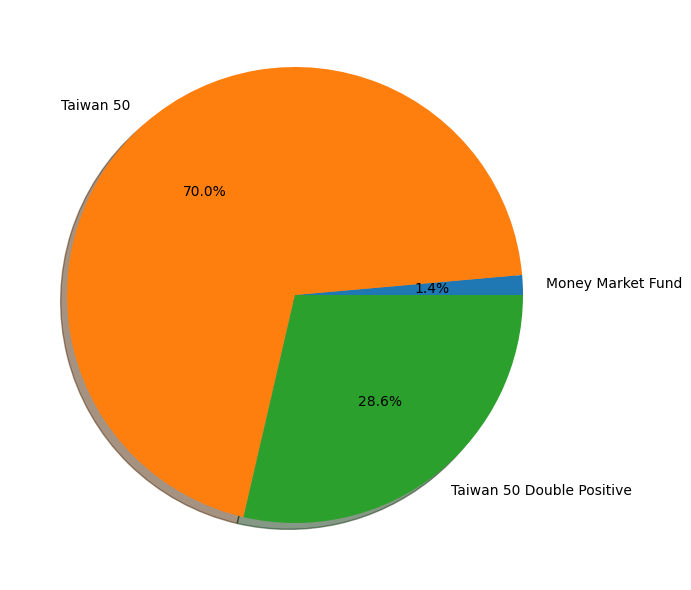

In [55]:
pd_cum_return_sector_2023_1.iloc[-1,:].plot(kind='pie', grid=True, figsize=(15, 6), fontsize=10, shadow=True, autopct='%1.1f%%')
plt.ylabel('')
plt.set_cmap("gist_rainbow")
plt.tight_layout()
plt.show()